Generate plots based on Fixed params dataset (fixed alpha, fr and tau, 1000 signals, 10 min length, spike_trains_tau100ms_alpha0_3_fr3_5hz_len600sec_1000.pkl)

In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import joypy

from isttc.scripts.cfg_global import project_folder_path

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
#dataset_folder = project_folder_path + 'results\\synthetic_data\\dataset\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\fixed_params\\'
fig_folder = project_folder_path + 'results\\synthetic\\fig_drafts_paper\\'

In [48]:
save_fig = True

### Load data

In [4]:
rate_hz     = 3.5     # target firing rate (Hz)
tau_ms      = 100.0    # desired autocorr time constant (ms)
alpha       = 0.3      # self‐excitation weight (must be <1)

In [ ]:
# # Compute firing rates (Hz)
# duration_s = duration_ms / 1000.0
# rates = [len(train) / duration_s for train in all_spike_trains]

# fig, axes = plt.subplots(1,1, figsize=(4,3))

# axes.hist(rates, bins=20, color='slategray', alpha=0.4)
# axes.axvline(x=target_fr_hz, color='salmon', label='target FR')
# axes.axvline(x=np.median(rates), color='steelblue', label='generated FR (median)')
# axes.set_xlabel('Firing rate (Hz)')
# axes.set_ylabel('Number of spike trains')
# axes.set_title(f'Target FR {target_fr_hz}Hz, \nmedian FR {np.round(np.median(rates),4)}Hz')
# axes.set_xlim([3,4])
# axes.legend(frameon=False, loc='upper right')

# sns.despine()

# if save_fig:
#     plt.savefig(fig_folder + 'dataset_fr_3_5hz.png' , bbox_inches='tight', dpi=300)
#     plt.savefig(fig_folder + 'dataset_fr_3_5hz.svg' , bbox_inches='tight')

In [5]:
with open(results_folder + 'acf_isttc_full_50ms_20lags_dict.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

with open(results_folder + 'acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

with open(results_folder + 'pearsonr_trial_avg_50ms_20lags_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_avg_50ms_20lags_dict.pkl', "rb") as f:
    sttc_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_concat_50ms_20lags_dict.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

print(f'len isttc_full_dict {len(isttc_full_dict)}')
print(f'len acf_full_dict {len(acf_full_dict)}')
print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
print(f'len sttc_trial_avg_dict {len(sttc_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')

len isttc_full_dict 1000
len acf_full_dict 1000
len pearsonr_trial_avg_dict 1000
len sttc_trial_avg_dict 1000
len sttc_trial_concat_dict 1000


### Make summary dfs

In [6]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [7]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [8]:
def get_trials_plot_df(trial_dict_, method_, n_iteration_=None):
    records = []
    for unit_id, data in trial_dict_.items():
        taus = data['taus']
        acfs = data['acf']

        if n_iteration_ is not None:
            # only one trial per unit
            idx = n_iteration_[unit_id]
            taus_to_iter = [(taus[idx], acfs[idx])]
        else:
            # all trials for this unit
            taus_to_iter = zip(taus, acfs)

        for tau_dict, acf_array in taus_to_iter:
            records.append({
                'unit_id': unit_id,
                'tau': tau_dict['tau'],
                'fit_r_squared': tau_dict['fit_r_squared'],
                'decline_150_250': calculate_acf_decline_flag(acf_array, start_idx=2, end_idx=4),
                'method': method_,
            })

    df = pd.DataFrame.from_records(records)
    df['tau_ms'] = df['tau'] * 50

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}')

    return df

In [9]:
data = []
for unit_id, unit_data in acf_full_dict.items():
    taus = unit_data['taus']  
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
acf_full_plot_df = pd.DataFrame(data)
acf_full_plot_df['method'] = 'acf_full'
acf_full_plot_df['tau_ms'] = acf_full_plot_df['tau'] * 50
acf_full_plot_df['tau_ms_true'] = tau_ms
acf_full_plot_df['tau_diff_abs'] = np.abs(acf_full_plot_df['tau_ms'] - acf_full_plot_df['tau_ms_true'])
acf_full_plot_df['tau_diff_rel'] = acf_full_plot_df['tau_diff_abs'] / acf_full_plot_df['tau_ms_true'] * 100

rows_with_nans_df = acf_full_plot_df[acf_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')
acf_full_plot_df['method'] = 'acf_full'

acf_full_plot_df.head(2)

N rows with NaNs 0


,unit_id,tau,fit_r_squared,decline_150_250,method,tau_ms,tau_ms_true,tau_diff_abs,tau_diff_rel
0,0,2.338126,0.932187,True,acf_full,116.906290,100.0,16.906290,16.906290
1,1,1.665427,0.966912,True,acf_full,83.271337,100.0,16.728663,16.728663


In [10]:
data = []
for unit_id, unit_data in isttc_full_dict.items():
    taus = unit_data['taus']      
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
isttc_full_plot_df = pd.DataFrame(data)
isttc_full_plot_df['method'] = 'isttc_full'
isttc_full_plot_df['tau_ms'] = isttc_full_plot_df['tau'] * 50
isttc_full_plot_df['tau_ms_true'] = tau_ms
isttc_full_plot_df['tau_diff_abs'] = np.abs(isttc_full_plot_df['tau_ms'] - isttc_full_plot_df['tau_ms_true'])
isttc_full_plot_df['tau_diff_rel'] = isttc_full_plot_df['tau_diff_abs'] / isttc_full_plot_df['tau_ms_true'] * 100

rows_with_nans_df = isttc_full_plot_df[isttc_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')

isttc_full_plot_df.head(2)

N rows with NaNs 0


,unit_id,tau,fit_r_squared,decline_150_250,method,tau_ms,tau_ms_true,tau_diff_abs,tau_diff_rel
0,0,2.512025,0.925774,False,isttc_full,125.601231,100.0,25.601231,25.601231
1,1,1.539509,0.958556,True,isttc_full,76.975439,100.0,23.024561,23.024561


In [11]:
gen_random_trials_ids = False
if gen_random_trials_ids:
    n_trials_impl = 50
    random_trials_impl_l = []
    for i in range(n_trials_impl):
        random_trials_impl_l.append(random.choices(range(0, 100), k=1000))
    
    with open(results_folder + 'random_trials_impl_50.pkl', "wb") as f:
        pickle.dump(random_trials_impl_l, f)
else:
    with open(results_folder + 'random_trials_impl_50.pkl', "rb") as f:
        random_trials_impl_l = pickle.load(f)

### Plots

In [43]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2'
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_avg =  '#a49fce' 
color_sttc_trail_concat = '#955da2' 

colors = [color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_avg, color_sttc_trail_concat]

In [13]:
def plot_one_threshold(axes_, percent_long_df):
    axes_.plot(
    percent_long_df.query('method == "pearsonr_trial_avg"')['interval'],
    percent_long_df.query('method == "pearsonr_trial_avg"')['percentage'],
    color=color_pearson_trail_avg, marker='o', markersize=5, linewidth=0.5, label='pearsonr_avg' 
    )
    axes_.plot(
    percent_long_df.query('method == "sttc_trial_avg"')['interval'],
    percent_long_df.query('method == "sttc_trial_avg"')['percentage'],
    color=color_sttc_trail_avg, marker='o', markersize=5, linewidth=0.5, label='sttc_avg' 
    )
    axes_.plot(
    percent_long_df.query('method == "sttc_trial_concat"')['interval'],
    percent_long_df.query('method == "sttc_trial_concat"')['percentage'],
    color=color_sttc_trail_concat, marker='o', markersize=5, linewidth=0.5, label='sttc_concat' 
    )
    axes_.plot(
    percent_long_df.query('method == "acf_full"')['interval'],
    percent_long_df.query('method == "acf_full"')['percentage'],
    color=color_acf_full, marker='o', markersize=5, linewidth=0.5, label='acf_full' 
    )
    axes_.plot(
    percent_long_df.query('method == "isttc_full"')['interval'],
    percent_long_df.query('method == "isttc_full"')['percentage'],
    color=color_isttc_full, marker='o', markersize=5, linewidth=0.5, label='isttc_full' 
    )

def plot_one_threshold_jittered_lines(ax, df, jitter=0.15, seed=None, plot_lines=False):
    if seed is not None:
        np.random.seed(seed)

    methods = [
        ("pearsonr_trial_avg", color_pearson_trail_avg, "pearsonr_avg"),
        ("sttc_trial_avg",     color_sttc_trail_avg,     "sttc_avg"),
        ("sttc_trial_concat",  color_sttc_trail_concat,  "sttc_concat"),
        ("acf_full",           color_acf_full,           "acf_full"),
        ("isttc_full",         color_isttc_full,         "isttc_full"),
    ]

    # fixed ordering of intervals
    cats = list(df["interval"].unique())
    idx_map = {cat:i for i,cat in enumerate(cats)}

    for method, col, label in methods:
        sub = df[df["method"] == method]
        # map string-labels to integer indices
        x0 = np.array([idx_map[s] for s in sub["interval"]])
        y  = sub["percentage"].values

        #  one jitter per point
        offsets = np.random.uniform(-jitter, jitter, size=len(x0))
        xj = x0 + offsets

        if plot_lines:
            order = np.argsort(x0)
            ax.plot(xj[order], y[order],
                    color=col,
                    linewidth=0.8,
                    alpha=1)
        # plot jittered points
        ax.scatter(xj, y,
                   color=col,
                   s=40,
                   marker="o",
                   label=label)

    ax.set_xticks(np.arange(len(cats)))
    ax.set_xticklabels(cats)

In [14]:
# intervals for error plots
intervals = {
    '+-100':   (0,   200),
    '+-75':  (25,  175),
    '+-50':  (50,  150),
    '+-25':  (75,  125),
}

#### Example plot for panel B

(for trial based measures one realization of trials is taken)

In [24]:
# df for example plot (for trial based measures one realization of trials is taken)
random_trials_impl = random_trials_impl_l[10]

pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg', random_trials_impl)
pearsontr_trial_avg_plot_df['tau_ms_true'] = tau_ms
pearsontr_trial_avg_plot_df['tau_diff_abs'] = np.abs(pearsontr_trial_avg_plot_df['tau_ms'] - pearsontr_trial_avg_plot_df['tau_ms_true'])
pearsontr_trial_avg_plot_df['tau_diff_rel'] = pearsontr_trial_avg_plot_df['tau_diff_abs'] / pearsontr_trial_avg_plot_df['tau_ms_true'] * 100

sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat', random_trials_impl)
sttc_trial_concat_plot_df['tau_ms_true'] = tau_ms
sttc_trial_concat_plot_df['tau_diff_abs'] = np.abs(sttc_trial_concat_plot_df['tau_ms'] - sttc_trial_concat_plot_df['tau_ms_true'])
sttc_trial_concat_plot_df['tau_diff_rel'] = sttc_trial_concat_plot_df['tau_diff_abs'] / sttc_trial_concat_plot_df['tau_ms_true'] * 100

sttc_trial_avg_plot_df = get_trials_plot_df(sttc_trial_avg_dict, 'sttc_trial_avg', random_trials_impl)
sttc_trial_avg_plot_df['tau_ms_true'] = tau_ms
sttc_trial_avg_plot_df['tau_diff_abs'] = np.abs(sttc_trial_avg_plot_df['tau_ms'] - sttc_trial_avg_plot_df['tau_ms_true'])
sttc_trial_avg_plot_df['tau_diff_rel'] = sttc_trial_avg_plot_df['tau_diff_abs'] / sttc_trial_avg_plot_df['tau_ms_true'] * 100

tau_5methods_one_trial_impl_df = pd.concat([acf_full_plot_df, isttc_full_plot_df, 
                                            pearsontr_trial_avg_plot_df, 
                                            sttc_trial_avg_plot_df, 
                                            sttc_trial_concat_plot_df])
tau_5methods_one_trial_impl_df['log_tau_ms'] = np.log10(tau_5methods_one_trial_impl_df['tau_ms'])
tau_5methods_one_trial_impl_df.reset_index(inplace=True, drop=True)

tau_5methods_one_trial_impl_df

N rows with NaNs 6


,unit_id,tau,fit_r_squared,decline_150_250,method,tau_ms,tau_ms_true,tau_diff_abs,tau_diff_rel,log_tau_ms
0,0,2.338126,0.932187,True,acf_full,1.169063e+02,100.0,1.690629e+01,1.690629e+01,2.067838
1,1,1.665427,0.966912,True,acf_full,8.327134e+01,100.0,1.672866e+01,1.672866e+01,1.920496
2,2,1.777164,0.940679,True,acf_full,8.885819e+01,100.0,1.114181e+01,1.114181e+01,1.948697
3,3,2.204418,0.915245,True,acf_full,1.102209e+02,100.0,1.022091e+01,1.022091e+01,2.042264
4,4,2.382246,0.899545,True,acf_full,1.191123e+02,100.0,1.911230e+01,1.911230e+01,2.075957
...,...,...,...,...,...,...,...,...,...,...
4995,995,1.556522,0.315105,True,sttc_trial_concat,7.782609e+01,100.0,2.217391e+01,2.217391e+01,1.891125
4996,996,55773.198013,0.349643,True,sttc_trial_concat,2.788660e+06,100.0,2.788560e+06,2.788560e+06,6.445396
4997,997,3.417495,0.677461,True,sttc_trial_concat,1.708747e+02,100.0,7.087473e+01,7.087473e+01,2.232678
4998,998,1.986306,0.032909,False,sttc_trial_concat,9.931530e+01,100.0,6.847041e-01,6.847041e-01,1.997016


In [16]:
df = tau_5methods_one_trial_impl_df.copy()

rows = []
for method, sub in df.groupby('method'):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_ms'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)

tau_5methods_one_trial_impl_error_df = pd.DataFrame(rows).set_index('method')

# make long df
tau_5methods_one_trial_impl_error_df = tau_5methods_one_trial_impl_error_df.reset_index()
tau_5methods_one_trial_impl_error_long_df = tau_5methods_one_trial_impl_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)
tau_5methods_one_trial_impl_error_long_df

,method,interval,percentage
0,acf_full,+-100,100.0
1,isttc_full,+-100,100.0
2,pearsonr_trial_avg,+-100,68.9
3,sttc_trial_avg,+-100,68.9
4,sttc_trial_concat,+-100,72.1
5,acf_full,+-75,99.8
6,isttc_full,+-75,99.7
7,pearsonr_trial_avg,+-75,52.1
8,sttc_trial_avg,+-75,51.7
9,sttc_trial_concat,+-75,56.6


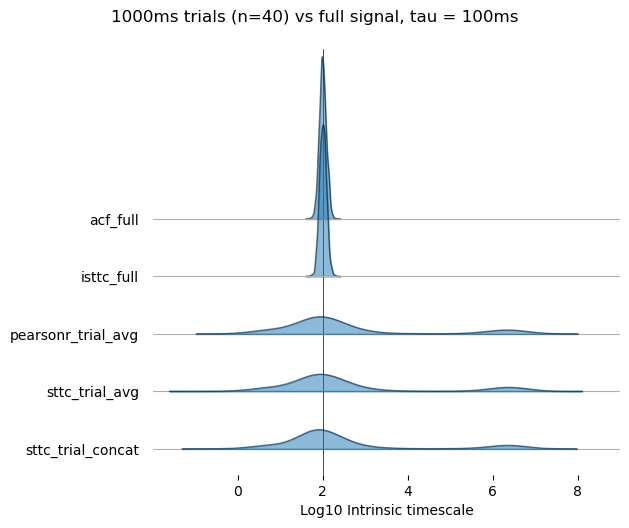

In [17]:
fig, axes = joypy.joyplot(data=tau_5methods_one_trial_impl_df,
    by='method',
    column='log_tau_ms',
    range_style='own',
    grid="y",
    kind='kde',
    overlap=2,
    alpha=0.5,
    linewidth=1,
    x_range=[-2,9]
)

axes[-1].axvline(x=2, color='k', lw=0.5)

axes[-1].set_xlabel('Log10 Intrinsic timescale')
fig.suptitle('1000ms trials (n=40) vs full signal, tau = 100ms', y=1.05)

if save_fig:
    plt.savefig(fig_folder + '100ms_5_methods_one_trial_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + '100ms_5_methods_one_trial_impl.svg' , bbox_inches='tight')

In [18]:
# get percentage of units with tau?ms in 200ms range
mask = tau_5methods_one_trial_impl_df['tau_ms'].between(0, 200)
tau_5methods_one_trial_impl_0_200ms_df = (
    tau_5methods_one_trial_impl_df
    .groupby('method')
    .agg(
        total       = ('tau_ms', 'size'),
        in_range    = ('tau_ms', lambda x: x.between(0,200).sum())
    )
)
tau_5methods_one_trial_impl_0_200ms_df['percent_in_range'] = tau_5methods_one_trial_impl_0_200ms_df['in_range'] / tau_5methods_one_trial_impl_0_200ms_df['total'] * 100
tau_5methods_one_trial_impl_0_200ms_df = tau_5methods_one_trial_impl_0_200ms_df.assign(
    percent_in_range=lambda d: d['percent_in_range'].map("{:.1f}%".format)
)
tau_5methods_one_trial_impl_0_200ms_df

,total,in_range,percent_in_range
method,,,
acf_full,1000,1000,100.0%
isttc_full,1000,1000,100.0%
pearsonr_trial_avg,1000,689,68.9%
sttc_trial_avg,1000,689,68.9%
sttc_trial_concat,1000,721,72.1%


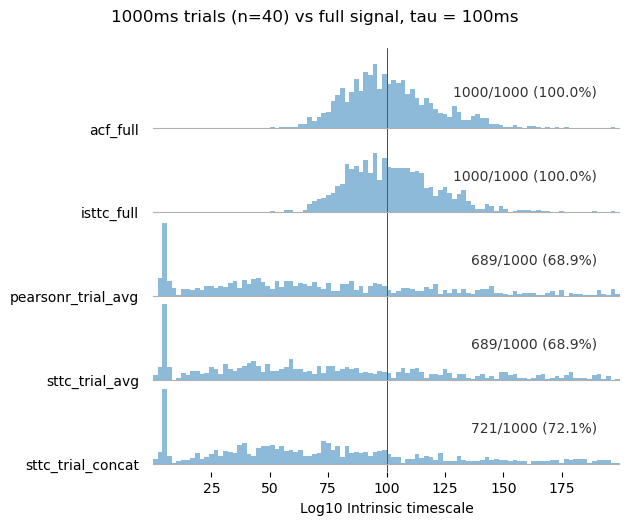

In [19]:
fig, axes = joypy.joyplot(data=tau_5methods_one_trial_impl_df.query('tau_ms > 0 and tau_ms < 200'),
    by='method',
    column='tau_ms',
    #range_style='own',
    ylim = 'max',
    grid="y",
    #kind='kde',
    hist=True, bins=100, fill=False,
    overlap=0.1,
    alpha=0.5,
    linewidth=1,
    x_range=[0,200]
)

axes[-1].axvline(x=100, color='k', lw=0.5)

axes[-1].set_xlabel('Log10 Intrinsic timescale')
fig.suptitle('1000ms trials (n=40) vs full signal, tau = 100ms', y=1.05)


method_order = [
    'acf_full',
    'isttc_full',
    'pearsonr_trial_avg',
    'sttc_trial_avg',
    'sttc_trial_concat',
]
for ax, method in zip(axes, method_order):
    tot    = tau_5methods_one_trial_impl_0_200ms_df.at[method, 'total']
    inn    = tau_5methods_one_trial_impl_0_200ms_df.at[method, 'in_range']
    pct    = tau_5methods_one_trial_impl_0_200ms_df.at[method, 'percent_in_range']
    txt    = f"{inn}/{tot} ({pct})"
    # place in axis‐relative coords (x=95% from left, y=center)
    ax.text(
        0.95, 0.5, txt,
        transform = ax.transAxes,
        ha        = 'right',
        va        = 'center',
        fontsize  = 10,
        alpha     = 0.8
    )

if save_fig:
    plt.savefig(fig_folder + '100ms_5_methods_one_trial_impl_hist.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + '100ms_5_methods_one_trial_impl_hist.svg' , bbox_inches='tight')

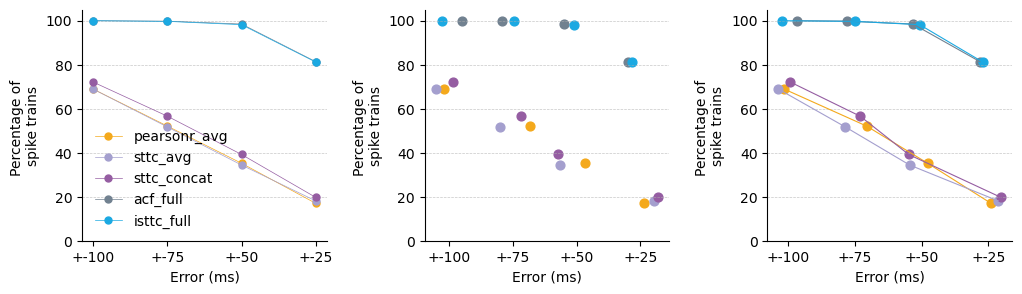

In [22]:
fig, axes = plt.subplots(1,3,figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_one_threshold(axes[0], tau_5methods_one_trial_impl_error_long_df)

plot_one_threshold_jittered_lines(axes[1],
    tau_5methods_one_trial_impl_error_long_df,
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[2],
    tau_5methods_one_trial_impl_error_long_df,
    jitter=0.2, seed=42, plot_lines=True)

for ax in axes.flat:
    ax.set_ylabel('Percentage of \nspike trains')
    ax.set_xlabel('Error (ms)')
    ax.set_ylim([0, 105])
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False)


if save_fig:
    plt.savefig(fig_folder + 'taus_error_one_trials_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_error_one_trials_impl.svg' , bbox_inches='tight')

#### Supp for Example plot for panel B

(for trial based measures 50 realization of trials are taken, error is median across 50 realizations)

In [ ]:
dfs = []

for idx, random_trials_impl in enumerate(random_trials_impl_l):
    # method’s df for this particular impl
    df_p = get_trials_plot_df(pearsonr_trial_avg_dict,
                              'pearsonr_trial_avg',
                              random_trials_impl)
    df_sa = get_trials_plot_df(sttc_trial_avg_dict,
                               'sttc_trial_avg',
                               random_trials_impl)
    df_sc = get_trials_plot_df(sttc_trial_concat_dict,
                               'sttc_trial_concat',
                               random_trials_impl)
    df_full = acf_full_plot_df.copy()
    df_isttc = acf_isttc_full_plot_df.copy()
    
    one_ex = pd.concat([df_full,
                        df_isttc,
                        df_p,
                        df_sa,
                        df_sc],
                       ignore_index=True)
    
    one_ex['log_tau_ms'] = np.log10(one_ex['tau_ms'])
    one_ex['random_trials_impl_idx'] = idx
    
    dfs.append(one_ex)

tau_5methods_50_trial_impl_df = pd.concat(dfs, ignore_index=True)

# sanity check
print(tau_5methods_50_trial_impl_df.shape)
print(tau_5methods_50_trial_impl_df['random_trials_impl_idx'].nunique(), 'unique impls')

In [ ]:
tau_5methods_50_trial_impl_df

In [ ]:
df = tau_5methods_50_trial_impl_df.copy()

rows = []
for idx, df_idx in df.groupby('random_trials_impl_idx'):
    total_idx = len(df_idx)
    for method, df_m in df_idx.groupby('method'):
        total_m = len(df_m)
        for name, (lo, hi) in intervals.items():
            cnt = df_m['tau_ms'].between(lo, hi).sum()
            rows.append({
                'random_trials_impl_idx': idx,
                'method': method,
                'interval': name,
                'percentage': cnt/total_m * 100
            })

tau_5methods_50_trial_impl_error_long_df = pd.DataFrame(rows)
tau_5methods_50_trial_impl_error_long_df

In [ ]:
tau_5methods_50_trial_impl_error_long_avg_df = (
    tau_5methods_50_trial_impl_error_long_df
    .groupby(['method','interval'])['percentage']
    .agg(
        median = 'median',
        lower_95 = lambda x: x.quantile(0.025),
        upper_95 = lambda x: x.quantile(0.975)
    )
    .reset_index()
)
tau_5methods_50_trial_impl_error_long_avg_df = tau_5methods_50_trial_impl_error_long_avg_df.rename(columns={'median': 'percentage'})
order = ['+-100', '+-75', '+-50', '+-25']
tau_5methods_50_trial_impl_error_long_avg_df['interval'] = pd.Categorical(
    tau_5methods_50_trial_impl_error_long_avg_df['interval'],
    categories=order,
    ordered=True
)
tau_5methods_50_trial_impl_error_long_avg_df.sort_values('interval', inplace=True)
tau_5methods_50_trial_impl_error_long_avg_df

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_one_threshold(axes[0], tau_5methods_50_trial_impl_error_long_avg_df)

plot_one_threshold_jittered_lines(axes[1],
    tau_5methods_50_trial_impl_error_long_avg_df,
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[2],
    tau_5methods_50_trial_impl_error_long_avg_df,
    jitter=0.2, seed=42, plot_lines=True)

for ax in axes.flat:
    ax.set_ylabel('Percentage of \nspike trains')
    ax.set_xlabel('Error (ms)')
    ax.set_ylim([0, 105])
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False)

if save_fig:
    plt.savefig(fig_folder + 'taus_error_50_trials_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_error_50_trials_impl.svg' , bbox_inches='tight')

#### For Panel D - error when 100 trial realizations are used to estimate tau

In [ ]:
pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg')
sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat')
sttc_trial_avg_plot_df = get_trials_plot_df(sttc_trial_avg_dict, 'sttc_trial_avg')

pearsontr_trial_avg_plot_df = pearsontr_trial_avg_plot_df.groupby(by=['unit_id', 'method'], as_index=False)[['tau_ms','fit_r_squared']].median()
sttc_trial_concat_plot_df = sttc_trial_concat_plot_df.groupby(by=['unit_id', 'method'], as_index=False)[['tau_ms','fit_r_squared']].median()
sttc_trial_avg_plot_df = sttc_trial_avg_plot_df.groupby(by=['unit_id', 'method'], as_index=False)[['tau_ms','fit_r_squared']].median()

pearsontr_trial_avg_plot_df['tau_ms_true'] = tau_ms
pearsontr_trial_avg_plot_df['tau_diff_abs'] = np.abs(pearsontr_trial_avg_plot_df['tau_ms'] - pearsontr_trial_avg_plot_df['tau_ms_true'])
pearsontr_trial_avg_plot_df['tau_diff_rel'] = pearsontr_trial_avg_plot_df['tau_diff_abs'] / pearsontr_trial_avg_plot_df['tau_ms_true'] * 100

sttc_trial_concat_plot_df['tau_ms_true'] = tau_ms
sttc_trial_concat_plot_df['tau_diff_abs'] = np.abs(sttc_trial_concat_plot_df['tau_ms'] - sttc_trial_concat_plot_df['tau_ms_true'])
sttc_trial_concat_plot_df['tau_diff_rel'] = sttc_trial_concat_plot_df['tau_diff_abs'] / sttc_trial_concat_plot_df['tau_ms_true'] * 100

sttc_trial_avg_plot_df['tau_ms_true'] = tau_ms
sttc_trial_avg_plot_df['tau_diff_abs'] = np.abs(sttc_trial_avg_plot_df['tau_ms'] - sttc_trial_avg_plot_df['tau_ms_true'])
sttc_trial_avg_plot_df['tau_diff_rel'] = sttc_trial_avg_plot_df['tau_diff_abs'] / sttc_trial_avg_plot_df['tau_ms_true'] * 100

tau_concat_avg_df = pd.concat([acf_full_plot_df, isttc_full_plot_df, 
                           pearsontr_trial_avg_plot_df, 
                               sttc_trial_concat_plot_df, 
                               sttc_trial_avg_plot_df])
tau_concat_avg_df['log_tau_ms'] = np.log10(tau_concat_avg_df['tau_ms'])
tau_concat_avg_df.reset_index(inplace=True, drop=True)
tau_concat_avg_df

In [ ]:
# tau_concat_df = pd.concat([acf_full_plot_df, acf_isttc_full_plot_df, 
#                            acf_pearsontr_trial_avg_df, 
#                                acf_sttc_trial_concat_df, 
#                                acf_sttc_trial_avg_df])
# tau_concat_df['log_tau_ms'] = np.log10(tau_concat_df['tau_ms'])
# tau_concat_df.reset_index(inplace=True, drop=True)
# tau_concat_df

# tau_concat_df.to_pickle(results_folder + 'tau_concat_df.pkl')

In [ ]:
df = tau_concat_avg_df.copy()

rows = []
for method, sub in df.groupby('method'):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_ms'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)

tau_5methods_100_trial_impl_avg_error_df = pd.DataFrame(rows).set_index('method')

tau_5methods_100_trial_impl_avg_error_df = tau_5methods_100_trial_impl_avg_error_df.reset_index()
tau_5methods_100_trial_impl_avg_error_long_df = tau_5methods_100_trial_impl_avg_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)
tau_5methods_100_trial_impl_avg_error_long_df

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_one_threshold(axes[0], tau_5methods_100_trial_impl_avg_error_long_df)

plot_one_threshold_jittered_lines(axes[1],
    tau_5methods_100_trial_impl_avg_error_long_df,
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[2],
    tau_5methods_100_trial_impl_avg_error_long_df,
    jitter=0.2, seed=42, plot_lines=True)

for ax in axes.flat:
    ax.set_ylabel('Percentage of \nspike trains')
    ax.set_xlabel('Error (ms)')
    ax.set_ylim([0, 105])
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    sns.despine(ax=ax)

axes[0].legend(frameon=False)

if save_fig:
    plt.savefig(fig_folder + 'taus_error_med_100_trials_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_error_med_100_trials_impl.svg' , bbox_inches='tight')

In [26]:
tau_concat_avg_df.describe()

NameError: name 'tau_concat_avg_df' is not defined

In [ ]:
fig, axes = joypy.joyplot(data=tau_concat_avg_df,
    by='method',
    column='tau_ms',
    range_style='own',
    grid="y",
    kind='kde',
    overlap=2,
    alpha=0.5,
    linewidth=1,
    x_range=[1, 250]
)

axes[-1].axvline(x=100, color='k', lw=0.5)

axes[-1].set_xlabel('Log10 Intrinsic timescale')
fig.suptitle('1000ms trials (n=40) x 100 realizations vs full signal, \ntau = 100ms', y=1.05)

# if save_fig:
#     plt.savefig(fig_folder + '100ms_5_methods_100_trial_impl_log.png' , bbox_inches='tight', dpi=300)
#     plt.savefig(fig_folder + '100ms_5_methods_100_trial_impl_log.svg' , bbox_inches='tight')

In [ ]:
# get percentage of units with tau?ms in 200ms range
mask = tau_concat_avg_df['tau_ms'].between(0, 200)
tau_concat_avg_0_200ms_df = (
    tau_concat_avg_df
    .groupby('method')
    .agg(
        total       = ('tau_ms', 'size'),
        in_range    = ('tau_ms', lambda x: x.between(0,200).sum())
    )
)
tau_concat_avg_0_200ms_df['percent_in_range'] = tau_concat_avg_0_200ms_df['in_range'] / tau_concat_avg_0_200ms_df['total'] * 100
tau_concat_avg_0_200ms_df = tau_concat_avg_0_200ms_df.assign(
    percent_in_range=lambda d: d['percent_in_range'].map("{:.1f}%".format)
)
tau_concat_avg_0_200ms_df

In [ ]:
fig, axes = joypy.joyplot(data=tau_concat_avg_df.query('tau_ms > 0 and tau_ms <= 200'),
    by='method',
    column='tau_ms',
    range_style='own',
    grid="y",
    #kind='kde',
    hist=True, bins=100, fill=False,
    overlap=0.1,
    alpha=0.5,
    linewidth=1,
    x_range=[0, 200]
)

axes[-1].axvline(x=100, color='k', lw=0.5)

axes[-1].set_xlabel('Log10 Intrinsic timescale')
fig.suptitle('1000ms trials (n=40) x 100 realizations vs full signal, \ntau = 100ms', y=1.05)

method_order = [
    'acf_full',
    'isttc_full',
    'pearsonr_trial_avg',
    'sttc_trial_avg',
    'sttc_trial_concat',
]
for ax, method in zip(axes, method_order):
    tot    = tau_concat_avg_0_200ms_df.at[method, 'total']
    inn    = tau_concat_avg_0_200ms_df.at[method, 'in_range']
    pct    = tau_concat_avg_0_200ms_df.at[method, 'percent_in_range']
    txt    = f"{inn}/{tot} ({pct})"
    # place in axis‐relative coords (x=95% from left, y=center)
    ax.text(
        0.95, 0.5, txt,
        transform = ax.transAxes,
        ha        = 'right',
        va        = 'center',
        fontsize  = 10,
        alpha     = 0.8
    )

if save_fig:
    plt.savefig(fig_folder + '100ms_5_methods_100_trial_impl_hist.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + '100ms_5_methods_100_trial_impl_hist.svg' , bbox_inches='tight')

#### Plot relative estimate error

In [25]:
# check for NaNs and for a long df remove rows with NaNs (if for a unit one method failed than remove it)

rows_with_nans_acf_df = acf_full_plot_df[acf_full_plot_df.isna().any(axis=1)]
n_rows_with_nan_acf = len(rows_with_nans_acf_df)
print(f'N rows with NaNs {n_rows_with_nan_acf}')

rows_with_nans_isttc_df = isttc_full_plot_df[isttc_full_plot_df.isna().any(axis=1)]
n_rows_with_nan_isttc = len(rows_with_nans_isttc_df)
print(f'N rows with NaNs {n_rows_with_nan_isttc}')

rows_with_nans_pearsonr_df = pearsontr_trial_avg_plot_df[pearsontr_trial_avg_plot_df.isna().any(axis=1)]
n_rows_with_nan_pearsonr = len(rows_with_nans_pearsonr_df)
print(f'N rows with NaNs {n_rows_with_nan_pearsonr}')

rows_with_nans_isttc_concat_df = sttc_trial_concat_plot_df[sttc_trial_concat_plot_df.isna().any(axis=1)]
n_rows_with_nan_isttc_concat = len(rows_with_nans_isttc_concat_df)
print(f'N rows with NaNs {n_rows_with_nan_isttc_concat}')

rows_with_nans_isttc_avg_df = sttc_trial_avg_plot_df[sttc_trial_avg_plot_df.isna().any(axis=1)]
n_rows_with_nan_isttc_avg = len(rows_with_nans_isttc_avg_df)
print(f'N rows with NaNs {n_rows_with_nan_isttc_avg}')

pearsonr_nan_unit_ids = rows_with_nans_pearsonr_df['unit_id'].values
sttc_concat_nan_unit_ids = rows_with_nans_isttc_concat_df['unit_id'].values
sttc_avg_nan_unit_ids = rows_with_nans_isttc_avg_df['unit_id'].values

unit_ids_nan_union = set(pearsonr_nan_unit_ids).union(sttc_concat_nan_unit_ids).union(sttc_avg_nan_unit_ids)
print(f'N rows in unit_ids_nan_union {len(unit_ids_nan_union)}')

# take rows without NaNs
pearsonr_sans_nans_plot_df = pearsontr_trial_avg_plot_df[~pearsontr_trial_avg_plot_df['unit_id'].isin(unit_ids_nan_union)]
sttc_concat_sans_nans_plot_df = sttc_trial_concat_plot_df[~sttc_trial_concat_plot_df['unit_id'].isin(unit_ids_nan_union)]
sttc_avg_sans_nans_plot_df = sttc_trial_avg_plot_df[~sttc_trial_avg_plot_df['unit_id'].isin(unit_ids_nan_union)]

print(f'len pearsonr {len(pearsonr_sans_nans_plot_df)}, len sttc_concat {len(sttc_concat_sans_nans_plot_df)}, len sttc_avg {len(sttc_avg_sans_nans_plot_df)}')

N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 6
N rows with NaNs 0
N rows with NaNs 0
N rows in unit_ids_nan_union 6
len pearsonr 994, len sttc_concat 994, len sttc_avg 994


In [27]:
# check for negative R-square

rows_with_negr_acf_df = acf_full_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_acf = len(rows_with_negr_acf_df)
print(f'N rows with neg R {n_rows_with_negr_acf}')

rows_with_negr_isttc_df = isttc_full_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc = len(rows_with_negr_isttc_df)
print(f'N rows with neg R {n_rows_with_negr_isttc}')

rows_with_negr_pearsonr_df = pearsonr_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_pearsonr = len(rows_with_negr_pearsonr_df)
print(f'N rows with neg R {n_rows_with_negr_pearsonr}')

rows_with_negr_isttc_concat_df = sttc_concat_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc_concat = len(rows_with_negr_isttc_concat_df)
print(f'N rows with neg R {n_rows_with_negr_isttc_concat}')

rows_with_negr_isttc_avg_df = sttc_avg_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc_avg = len(rows_with_negr_isttc_avg_df)
print(f'N rows with neg R {n_rows_with_negr_isttc_avg}')

pearsonr_negr_unit_ids = rows_with_negr_pearsonr_df['unit_id'].values
isttc_concat_negr_unit_ids = rows_with_negr_isttc_concat_df['unit_id'].values
isttc_avg_negr_unit_ids = rows_with_negr_isttc_avg_df['unit_id'].values

unit_ids_negr_union = set(pearsonr_negr_unit_ids).union(isttc_concat_negr_unit_ids).union(isttc_avg_negr_unit_ids)
print(f'N rows in unit_ids_negr_union {len(unit_ids_negr_union)}, : {unit_ids_negr_union}')

pearsonr_sans_negr_plot_df = pearsonr_sans_nans_plot_df[~pearsonr_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
sttc_concat_sans_negr_plot_df = sttc_concat_sans_nans_plot_df[~sttc_concat_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
sttc_avg_sans_negr_plot_df = sttc_avg_sans_nans_plot_df[~sttc_avg_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()

pearsonr_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(pearsonr_sans_negr_plot_df['tau_diff_rel'])
sttc_concat_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(sttc_concat_sans_negr_plot_df['tau_diff_rel'])
sttc_avg_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(sttc_avg_sans_negr_plot_df['tau_diff_rel'])

print(f'len pearsonr {len(pearsonr_sans_negr_plot_df)}, len sttc_concat {len(sttc_concat_sans_negr_plot_df)}, len sttc_avg {len(sttc_avg_sans_negr_plot_df)}')

N rows with neg R 0
N rows with neg R 0
N rows with neg R 16
N rows with neg R 13
N rows with neg R 16
N rows in unit_ids_negr_union 28, : {np.int64(768), np.int64(387), np.int64(900), np.int64(902), np.int64(904), np.int64(333), np.int64(14), np.int64(142), np.int64(86), np.int64(87), np.int64(24), np.int64(153), np.int64(90), np.int64(475), np.int64(859), np.int64(154), np.int64(162), np.int64(35), np.int64(357), np.int64(680), np.int64(937), np.int64(426), np.int64(109), np.int64(624), np.int64(944), np.int64(500), np.int64(954), np.int64(766)}
len pearsonr 966, len sttc_concat 966, len sttc_avg 966


In [38]:
acf_full_plot_df['tau_diff_rel_log10'] = np.log10(acf_full_plot_df['tau_diff_rel'])
isttc_full_plot_df['tau_diff_rel_log10'] = np.log10(isttc_full_plot_df['tau_diff_rel'])

tau_rel_error_long_df = pd.concat([acf_full_plot_df, 
                                   isttc_full_plot_df, 
                                   pearsonr_sans_negr_plot_df, 
                                   sttc_concat_sans_negr_plot_df, 
                                   sttc_avg_sans_negr_plot_df])
tau_rel_error_long_df['log_tau_ms'] = np.log10(tau_rel_error_long_df['tau_ms'])
tau_rel_error_long_df.reset_index(inplace=True, drop=True)

print(f'len tau_rel_error_long_df {len(tau_rel_error_long_df)}')

len tau_rel_error_long_df 4898


In [39]:
tau_rel_error_long_df

,unit_id,tau,fit_r_squared,decline_150_250,method,tau_ms,tau_ms_true,tau_diff_abs,tau_diff_rel,tau_diff_rel_log10,log_tau_ms
0,0,2.338126,0.932187,True,acf_full,1.169063e+02,100.0,1.690629e+01,1.690629e+01,1.228048,2.067838
1,1,1.665427,0.966912,True,acf_full,8.327134e+01,100.0,1.672866e+01,1.672866e+01,1.223461,1.920496
2,2,1.777164,0.940679,True,acf_full,8.885819e+01,100.0,1.114181e+01,1.114181e+01,1.046956,1.948697
3,3,2.204418,0.915245,True,acf_full,1.102209e+02,100.0,1.022091e+01,1.022091e+01,1.009490,2.042264
4,4,2.382246,0.899545,True,acf_full,1.191123e+02,100.0,1.911230e+01,1.911230e+01,1.281313,2.075957
...,...,...,...,...,...,...,...,...,...,...,...
4893,995,1.670459,0.328981,True,sttc_trial_avg,8.352296e+01,100.0,1.647704e+01,1.647704e+01,1.216879,1.921806
4894,996,82059.846030,0.303340,True,sttc_trial_avg,4.102992e+06,100.0,4.102892e+06,4.102892e+06,6.613090,6.613101
4895,997,33.017651,0.467265,False,sttc_trial_avg,1.650883e+03,100.0,1.550883e+03,1.550883e+03,3.190579,3.217716
4896,998,0.098863,0.096516,False,sttc_trial_avg,4.943174e+00,100.0,9.505683e+01,9.505683e+01,1.977983,0.694006


In [35]:
tau_rel_error_long_df.groupby(by='method', as_index=False)['tau_diff_rel'].median()

,method,tau_diff_rel
0,acf_full,12.347259
1,isttc_full,12.825256
2,pearsonr_trial_avg,69.614830
3,sttc_trial_avg,69.108777
4,sttc_trial_concat,62.894785


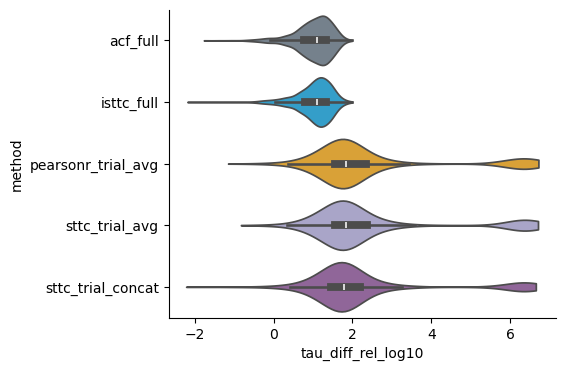

In [49]:
method_order = ['acf_full', 'isttc_full', 'pearsonr_trial_avg', 'sttc_trial_avg', 'sttc_trial_concat']
fig, axes = plt.subplots(1,1, figsize=(5, 4))

sns.violinplot(y='method', x='tau_diff_rel_log10', hue='method', order=method_order, hue_order=method_order, 
               palette=colors, data=tau_rel_error_long_df, cut=0, ax=axes)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + '100ms_5_methods_one_trial_impl_rel_error.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + '100ms_5_methods_one_trial_impl_rel_error.svg' , bbox_inches='tight')

#### Export for stats

In [ ]:
tau_concat_avg_df.to_csv(results_folder + 'tau_5methods_100trial_impl.csv')